# Initialization:

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import linear_model, datasets
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Reading the data:

Data source: Baby names recorded in Social Security Card Applications from 1910 to 2016. 

https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-data-by-state-and-district-of-

Read the data files and stack the state data on top of each other:

In [2]:
path="C:/Users/Abin/Desktop/state/"
data = pd.DataFrame()

for state in [x[:2] for x in os.listdir(path) if len(x)==6]:
    state_data = pd.read_csv(path +state + ".TXT",header=None,names=["State", "Gender", "Year", "Name", "Count"])
    data = pd.concat([data, state_data])

data = data[["Name", "Year", "Gender", "State", "Count"]].set_index('Name')
data.sample(5)

,Year,Gender,State,Count
Name,,,,
Vester,1916,M,NC,8
Janie,1945,F,KY,27
Brooke,1995,F,GA,161
Arnold,1944,M,AZ,14
Winter,1998,F,PA,6


# Analysis:

Create a summary by summing over all states for a specific name for each year:

In [3]:
data_sum=data.pivot_table(values='Count', index='Year' , columns='Name', aggfunc=sum).fillna(0).reset_index().rename_axis(None, axis=1).rename_axis(None, axis=0).set_index('Year')
data_sum.sample(5)

,Aaban,Aadan,Aadarsh,Aaden,Aadhav,Aadhya,Aadi,Aadil,Aadin,Aadit,...,Zyonna,Zyquan,Zyquavious,Zyra,Zyrah,Zyren,Zyria,Zyriah,Zyron,Zyshonne
Year,,,,,,,,,,,,,,,,,,,,,
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0
1912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,229.0,0.0,20.0,6.0,0.0,0.0,0.0,...,6.0,0.0,0.0,5.0,5.0,0.0,5.0,6.0,0.0,0.0
1921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Query data for years after 2000 to be used in finding 'Hot' names. i.e., names that are increasing in time: 

In [4]:
new_data_sum=data_sum[data_sum.index>2000]

Use linear regression on the new data summary to find the trend (decreasing, stable, increasing) of each name:

In [6]:
regr = linear_model.LinearRegression()
X=new_data_sum.index.values.astype(float).reshape(-1, 1)
regr=regr.fit(X, new_data_sum.values)

Create a data frame to be used for plotting the decision boundaries of classification:

In [90]:
slope=pd.DataFrame(regr.coef_.T,columns=new_data_sum.columns).T.reset_index()
slope.columns = ['index', 'regression_slope']
slope=slope.set_index('index').sort_values('regression_slope', ascending = 0)
slope.head()

,regression_slope
index,
Liam,1274.311765
Harper,823.544118
Sophia,820.688235
Mason,782.107353
Ava,778.020588


In order to classify based on trends, split the data based on the slope of the regression line:

In [91]:
divisions_bins = [-2000,-10,10,2000]
slope['trend_status'] = pd.cut(slope['regression_slope'],divisions_bins,right=False,labels=['decreasing','stable','Hot'])
slope.sample(5)

,regression_slope,trend_status
index,,
Nalia,0.625000,stable
Aubryana,0.035294,stable
Tarrance,0.000000,stable
Temmy,0.010294,stable
Ageliki,0.000000,stable


Getting the statistics of the data based on the trend classification:

In [92]:
slope.trend_status.value_counts().astype(float)/float(len(slope))

stable        0.930322
Hot           0.036209
decreasing    0.033469
Name: trend_status, dtype: float64

Therefore, 93% of the names have a stable trend. Only 4% are Hot which matches my assumption about the Hot names.

Going back to the original data, add the mean column by averaging through years:

In [74]:
data_sum_stats=data_sum.copy()
data_sum_stats.loc['count_mean'] = data_sum_stats.mean()

Sort the new data summary by 'count_mean' to see which names are the most 'Popular':

In [75]:
data_sum_stats=data_sum_stats.T.reset_index().rename_axis(None, axis=1).set_index('index').sort_values('count_mean', ascending = 0)
data_sum_stats.head()

,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,count_mean
index,,,,,,,,,,,,,,,,,,,,,
James,9203.0,9980.0,17683.0,20880.0,26326.0,33890.0,35702.0,37472.0,42295.0,42551.0,...,15170.0,14199.0,13870.0,13239.0,13404.0,13540.0,14408.0,14785.0,14790.0,46610.242991
John,11479.0,13469.0,24662.0,29401.0,38051.0,47717.0,50219.0,52053.0,56772.0,53777.0,...,13313.0,12109.0,11550.0,11033.0,10611.0,10695.0,10675.0,10360.0,9952.0,45479.457944
Robert,5609.0,6524.0,12852.0,15707.0,21208.0,28801.0,31803.0,35338.0,40752.0,41158.0,...,8822.0,7818.0,7547.0,6964.0,6937.0,6698.0,6623.0,6100.0,5953.0,44282.280374
Michael,795.0,1114.0,2068.0,2566.0,3314.0,4046.0,4180.0,4258.0,4259.0,3896.0,...,20619.0,18932.0,17336.0,16775.0,16143.0,15468.0,15431.0,14406.0,14004.0,40578.878505
William,8849.0,10603.0,19648.0,23579.0,29801.0,38635.0,40516.0,42534.0,45408.0,44103.0,...,18386.0,17908.0,17042.0,17331.0,16872.0,16612.0,16798.0,15863.0,15668.0,36180.289720


Plot the histogram of averages of all names to find the 'Popular' names:

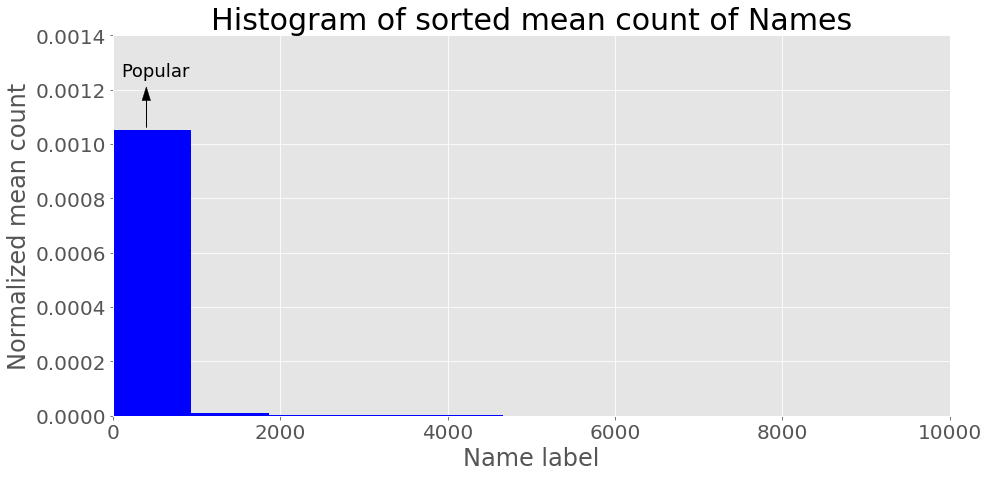

In [76]:
plt.figure(figsize=(15,7))
(n, bins, patches) = plt.hist(data_sum_stats['count_mean'],normed=True,bins=50,color='blue')
plt.ylabel('Normalized mean count', fontsize=24)
plt.xlabel('Name label', fontsize=24)
plt.title('Histogram of sorted mean count of Names', fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.axis([0, 10000, 0, 0.0014])
plt.arrow(400, 0.00106, 0, 0.0001, head_width=100,  head_length=0.00005, fc='k', ec='k')
plt.text(100, 0.0013, 'Popular', fontsize=18,color='black',verticalalignment='top')
plt.show()

The histogram shows that the 'Popular' names are the ones in the bin with a maximum height (first bin). Hence, to classify the data based on popularity, divide the data based on the names with labels that are smaller than the width of the first bin as cutoff values :

In [78]:
count_cutoff = bins[1]
count_cutoff

932.2506542056075

In [79]:
(data_sum_stats.count_mean >= count_cutoff).mean()

0.019507319275166055

Hence, 2% of the names have mean count higher than the cuttoff value. This is a reasonable value for  'Popular' names. 

In [80]:
data_sum_stats['is_popular'] = data_sum_stats.count_mean  >= count_cutoff

Use the obtained treshold for popularity to complete the previous clasification (based on trend): 

In [93]:
slope['is_popular']=data_sum_stats['is_popular']
slope['count_mean']=data_sum_stats['count_mean']
slope.sample(5)

,regression_slope,trend_status,is_popular,count_mean
index,,,,
Kamdyn,22.676471,Hot,False,17.850467
Blake,13.057353,Hot,True,1619.457944
Woodson,0.000000,stable,False,0.514019
Russel,-0.382353,stable,False,100.000000
Deloria,0.000000,stable,False,0.065421


Plot the results of final classification with all the decision boundaries:

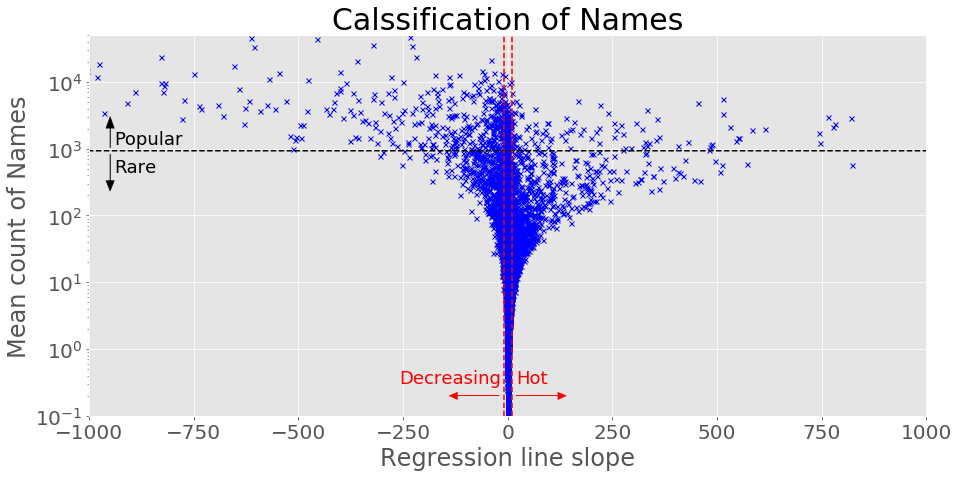

In [95]:
plt.figure(figsize=(15,7))
plt.semilogy(slope['regression_slope'], slope['count_mean'], 'x', markersize=5, label='original data', color='blue')
horiz_line_data = np.array([count_cutoff for i in range(0,len(slope))])
plt.plot(slope['regression_slope'], horiz_line_data, '--',color='black') 
plt.axvline(x=-10,linestyle='dashed',color='r')
plt.axvline(x=10,linestyle='dashed',color='r')  
plt.arrow(-950, count_cutoff+100, 0, 1000, head_width=20, head_length=1000, fc='k', ec='k')
plt.arrow(-950, count_cutoff-100, 0, -500, head_width=20,  head_length=100, fc='k', ec='k')
plt.arrow(-20, 0.2, -100, 0, head_width=0.05,  head_length=20, fc='r', ec='r')
plt.arrow(20, 0.2, 100, 0, head_width=0.05,  head_length=20, fc='r', ec='r')
plt.text(-940, count_cutoff+1000, 'Popular', fontsize=18,color='black',verticalalignment='top')
plt.text(-940, count_cutoff-200, 'Rare', fontsize=18,color='black',verticalalignment='top')
plt.text(-260, 0.5, 'Decreasing', fontsize=18,color='red',verticalalignment='top')
plt.text(20, 0.5, 'Hot', fontsize=18,color='red',verticalalignment='top')
plt.ylabel('Mean count of Names', fontsize=24)
plt.xlabel('Regression line slope', fontsize=24)
plt.title('Calssification of Names', fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.axis([-1000, 1000, 0.1, 50000])
plt.show()